In [2]:
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import pickle
import random

from tqdm.notebook import tqdm

from sklearn.model_selection import StratifiedKFold

from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc
)

from xgb_model import train_model, test_model
from utils import (
    prepare_data,
    censor_after,
    produce_stats,
    provide_stratified_bootstap_sample_indices,
    get_confidence_interval,
    load_params,
)

random.seed(99)
np.random.seed(99)

FRACTURES = ["vertebral_fracture", "hip_fracture", "any_fracture"]

# Define times at which to measure AUC (every year)
TIMES = np.arange(12, 95, 12)
TIME_TO_EVALUATE = 24

In [2]:
# Load data
train_data = pd.read_csv("data/final/train.csv", parse_dates=["date"])
test_data = pd.read_csv("data/final/test.csv", parse_dates=["date"])

## Cox PH model

vertebral
------------- train -------------
Harrels C-Index (Global): 0.7125
Harrels C-Index (at t=24): 0.71
Unos C-Index: 0.7072
------------- valid -------------
Harrels C-Index (Global): 0.6661
Harrels C-Index (at t=24): 0.6645
Unos C-Index: 0.6622
AUC at 2y: 0.6728
Mean AUC: 0.6972

hip
------------- train -------------
Harrels C-Index (Global): 0.7598
Harrels C-Index (at t=24): 0.7531
Unos C-Index: 0.7556
------------- valid -------------
Harrels C-Index (Global): 0.6615
Harrels C-Index (at t=24): 0.6538
Unos C-Index: 0.6572
AUC at 2y: 0.6644
Mean AUC: 0.6734

any
------------- train -------------
Harrels C-Index (Global): 0.6489
Harrels C-Index (at t=24): 0.6451
Unos C-Index: 0.6441
------------- valid -------------
Harrels C-Index (Global): 0.6242
Harrels C-Index (at t=24): 0.6215
Unos C-Index: 0.6203
AUC at 2y: 0.6344
Mean AUC: 0.656



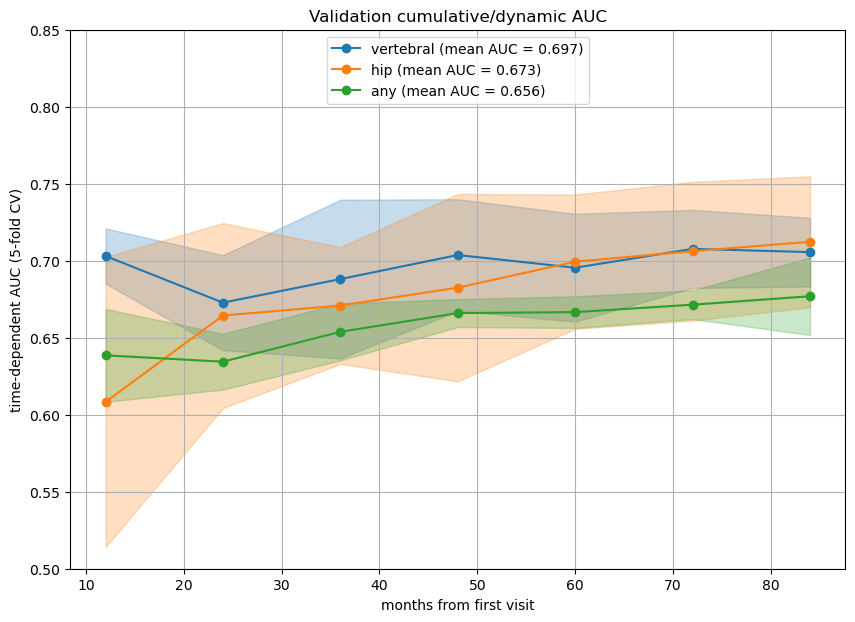

In [3]:
# Setup dataframe to store statistics in
multi_index = pd.MultiIndex.from_tuples([(x, y) for x in ["vertebral", "hip", "any"] for y in ["train", "valid", "test"]])
df_stats = pd.DataFrame([], index=multi_index, columns=["harrel_global", "harrel_2y", "uno_2y", "auc_2y", "auc_mean"])

model_name = "cox" 
cv = 5
kf = StratifiedKFold(n_splits=cv)
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
for i, fx in enumerate(FRACTURES):
    fx_type = fx.split("_")[0]
    print(fx_type)
    
    c_index_scores = {"train": {}, "valid": {}}
    auc_scores = {}
    for _, (train_index, validation_index) in enumerate(kf.split(train_data, train_data.loc[:,"any_right_censored"])):
        
        # Split train and validation set
        train_prepped = prepare_data(train_data.loc[train_index, :], fx_type, only_first_visits=True, standardize=True)
        X_train, y_train, scaler = train_prepped["X"], train_prepped["y"], train_prepped["scaler"]
        valid_prepped = prepare_data(train_data.loc[validation_index, :], fx_type, scaler, only_first_visits=True, standardize=True)
        X_valid, y_valid = valid_prepped["X"], valid_prepped["y"]
        
        assert X_train.isna().sum().sum() == 0
        assert y_valid["Event_observed"].sum() > 0
        
        # Train model
        model = CoxPHSurvivalAnalysis()
        model.fit(X_train, y_train)
        
        for tv in ["train", "valid"]:
            if tv == "train":
                X, y = X_train, y_train
            else:
                X, y = X_valid, y_valid
                
            # Compute cumlutaive hazard functions over time for each patient
            # They can be understood as our risk scores at a specific time
            chf_funcs = model.predict_cumulative_hazard_function(X, return_array=False)
            risk_scores = np.row_stack([chf(TIMES) for chf in chf_funcs])
            
            # Censor events after time t
            y_censored = censor_after(y, TIME_TO_EVALUATE)
            
            # Compute Harrel's and Uno's C-Index
            c_index_harrel_glob = model.score(X, y)
            c_index_harrel, _, _, _, _ = concordance_index_censored(y_censored["Event_observed"], y_censored["Survival_in_months"], [chf(TIME_TO_EVALUATE) for chf in chf_funcs])
            c_index_uno, _, _, _, _ = concordance_index_ipcw(y_train, y_censored, [chf(TIME_TO_EVALUATE) for chf in chf_funcs])
            c_index_scores[tv].setdefault(f"{fx_type}_harrel_global", list()).append(c_index_harrel_glob)
            c_index_scores[tv].setdefault(f"{fx_type}_harrel", list()).append(c_index_harrel)
            c_index_scores[tv].setdefault(f"{fx_type}_uno", list()).append(c_index_uno)

        # Compute cululative/dynamic AUC
        auc, mean_auc = cumulative_dynamic_auc(y_train, y_valid, risk_scores, TIMES)
        auc_scores.setdefault(fx_type, list()).append(auc)
        auc_scores.setdefault(f"{fx_type}_mean", list()).append(mean_auc)
    
    # Print C-Index Scores
    df_stats = produce_stats(df_stats, c_index_scores, auc_scores)
    
    # Plot the cumulative/dynamic AUC scores
    ax.plot(TIMES, np.mean(auc_scores[fx_type], axis=0), "o-", label="{} (mean AUC = {:.3f})".format(fx_type, np.mean(auc_scores[f"{fx_type}_mean"])))
    
    # 95% confidence intervals
    #alpha = 0.95
    #lower = np.percentile(auc_scores[fx_type], ((1.0-alpha)/2.0) * 100, axis=0)
    #upper = np.percentile(auc_scores[fx_type], (alpha+((1.0-alpha)/2.0)) * 100, axis=0)
    lower = np.mean(auc_scores[fx_type], axis=0) - np.std(auc_scores[fx_type], axis=0)
    upper = np.mean(auc_scores[fx_type], axis=0) + np.std(auc_scores[fx_type], axis=0)
    ax.fill_between(TIMES, lower, upper, color=f'C{i}', alpha=0.25)
    
    ax.set_title("Validation cumulative/dynamic AUC")
    ax.set_ylim(0.5, 0.85)
    ax.set_xlabel("months from first visit")
    ax.set_ylabel("time-dependent AUC (5-fold CV)")
    ax.legend(loc="upper center")
    ax.grid(True)
    print()

vertebral


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': 0.6864, 'harrel_2y': 0.6747, 'uno_2y': {'c-index': 0.6704, 'lower': 0.623, 'upper': 0.725}, 'auc': 0.69, 'auc_mean': 0.7315}

hip


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': 0.699, 'harrel_2y': 0.7006, 'uno_2y': {'c-index': 0.6991, 'lower': 0.626, 'upper': 0.773}, 'auc': 0.711, 'auc_mean': 0.712}

any


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': 0.6258, 'harrel_2y': 0.6194, 'uno_2y': {'c-index': 0.6199, 'lower': 0.586, 'upper': 0.651}, 'auc': 0.6415, 'auc_mean': 0.6636}



harrel_global harrel_2y  uno_2y  auc_2y auc_mean
vertebral train        0.7125      0.71  0.7072     NaN      NaN
          valid        0.6661    0.6645  0.6622  0.6728   0.6972
          test         0.6864    0.6747  0.6704    0.69   0.7315
hip       train        0.7598    0.7531  0.7556     NaN      NaN
          valid        0.6615    0.6538  0.6572  0.6644   0.6734
          test          0.699    0.7006  0.6991   0.711    0.712
any       train        0.6489    0.6451  0.6441     NaN      NaN
          valid        0.6242    0.6215  0.6203  0.6344    0.656
          test         0.6258    0.6194  0.6199  0.6415   0.6636

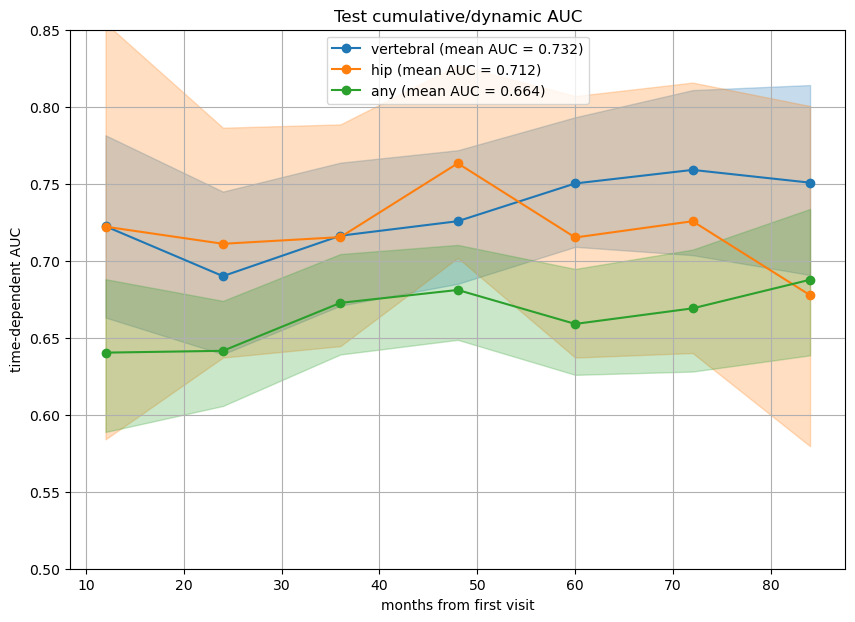

In [4]:
random.seed(99)
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
test_scores = {}
for i, fx in enumerate(FRACTURES):
    fx_type = fx.split("_")[0]
    print(fx_type)
    
    train_prepped = prepare_data(train_data, fx_type, only_first_visits=True, standardize=True)
    X_train, y_train, scaler = train_prepped["X"], train_prepped["y"], train_prepped["scaler"]
    
    model = CoxPHSurvivalAnalysis()
        
    # Train model
    model.fit(X_train, y_train)
    
    # Save model and scaler
    pickle.dump(model, open(f"models/cox/{fx_type}.pkl", "wb"))
    if i == 0:
        pickle.dump(scaler, open(f"models/cox/scaler.pkl", "wb"))
    
    c_index_scores = {"harrel_global": [], "harrel_2y": [], "uno_2y": []}
    auc_scores = {"auc": [], "mean_auc": []}
    # Bootstrap test set with 1000 samples
    n_bootstrap = 1000
    for bootsrap_idx in tqdm(range(n_bootstrap)):
        bs_sample = test_data.copy()
        
        # Create bootstrap sample
        bs_index_list_stratified = provide_stratified_bootstap_sample_indices(bs_sample, fx_type)
        bs_sample = bs_sample.loc[bs_index_list_stratified , :]

        test_prepped = prepare_data(bs_sample, fx_type, scaler, only_first_visits=True, standardize=True)
        X_test, y_test = test_prepped["X"], test_prepped["y"]
                
        # Compute cumlutaive hazard functions over time for each patient
        # They can be understood as our risk scores at a specific time
        chf_funcs = model.predict_cumulative_hazard_function(X_test)
        risk_scores = [chf(TIME_TO_EVALUATE) for chf in chf_funcs]
    
        # Censor events after time t
        y_test_censored = censor_after(y_test, TIME_TO_EVALUATE)
            
        # Compute Harrel's and Uno's C-Index
        c_index_harrel_glob = model.score(X_test, y_test)
        c_index_harrel, _, _, _, _ = concordance_index_censored(y_test_censored["Event_observed"], y_test_censored["Survival_in_months"], risk_scores)
        c_index_uno, _, _, _, _ = concordance_index_ipcw(y_test, y_test_censored, risk_scores)
        c_index_scores["harrel_global"].append(c_index_harrel_glob)
        c_index_scores["harrel_2y"].append(c_index_harrel)
        c_index_scores["uno_2y"].append(c_index_uno)
        
        # Compute and plot cululative/dynamic AUC
        auc, mean_auc = cumulative_dynamic_auc(y_test, y_test, risk_scores, TIMES)
        auc_scores["auc"].append(auc)
        auc_scores["mean_auc"].append(mean_auc)
    
    # 95% confidence intervals
    uno_lower, uno_upper = get_confidence_interval(c_index_scores["uno_2y"], alpha=0.95, decimals=3)
    test_scores[fx_type] = {
        "harrel_global": round(np.mean(c_index_scores["harrel_global"]), 4),
        "harrel_2y": round(np.mean(c_index_scores["harrel_2y"]), 4),
        "uno_2y": {
            "c-index": round(np.mean(c_index_scores['uno_2y']), 4),
            "lower": uno_lower,
            "upper": uno_upper,
        },
        "auc": round(np.mean(auc_scores["auc"], axis=0)[(TIME_TO_EVALUATE // 12) - 1], 4),
        "auc_mean": round(np.mean(auc_scores["mean_auc"]), 4)
    }
    print(test_scores[fx_type])
    
    # Compute and plot cululative/dynamic AUC
    ax.plot(TIMES, np.mean(auc_scores["auc"], axis=0), "o-", color=f'C{i}', label="{} (mean AUC = {:.3f})".format(fx_type, np.mean(auc_scores["mean_auc"])))
    
    # 95% confidence intervals
    lower, upper = get_confidence_interval(auc_scores["auc"], alpha=0.95, ax=0)
    ax.fill_between(TIMES, lower, upper, color=f'C{i}', alpha=0.25)
    
    ax.set_title("Test cumulative/dynamic AUC")
    ax.set_ylim(0.5, 0.85)
    ax.set_xlabel("months from first visit")
    ax.set_ylabel("time-dependent AUC")
    ax.legend(loc="upper center")
    ax.grid(True)
    
    # Add to df_stats
    df_stats.loc[(fx_type, "test"), "harrel_global"] = round(np.mean(c_index_scores["harrel_global"]), 4)
    df_stats.loc[(fx_type, "test"), "harrel_2y"] = round(np.mean(c_index_scores["harrel_2y"]), 4)
    df_stats.loc[(fx_type, "test"), "uno_2y"] = round(np.mean(c_index_scores['uno_2y']), 4)
    df_stats.loc[(fx_type, "test"), "auc_2y"] = round(np.mean(auc_scores["auc"], axis=0)[(TIME_TO_EVALUATE // 12) - 1], 4)
    df_stats.loc[(fx_type, "test"), "auc_mean"] = round(np.mean(auc_scores["mean_auc"]), 4)
    
    print()
    
    with open(f"results/c_index_scores/cox/{fx_type}.json", "w") as f:
        json.dump(c_index_scores, f)

# Save test scores
with open("results/cox_test_scores.json", "w") as f:
    json.dump(test_scores, f)

df_stats

## Random Survival Forest

In [5]:
best_params = {
    "vertebral": {
        "n_estimators": 100, 
        "max_depth": 5,
        "min_samples_split": 15,
        "min_samples_leaf": 5
    },
    "hip": {
        "n_estimators": 250, 
        "max_depth": 4,
        "min_samples_split": 7,
        "min_samples_leaf": 3
    },
    "any": {
        "n_estimators": 250, 
        "max_depth": 4,
        "min_samples_split": 15,
        "min_samples_leaf": 4
    },
}

vertebral
------------- train -------------
Harrels C-Index (Global): 0.7685
Harrels C-Index (at t=24): 0.7924
Unos C-Index: 0.7922
------------- valid -------------
Harrels C-Index (Global): 0.6818
Harrels C-Index (at t=24): 0.6714
Unos C-Index: 0.671
AUC at 2y: 0.6839
Mean AUC: 0.704

hip
------------- train -------------
Harrels C-Index (Global): 0.8187
Harrels C-Index (at t=24): 0.8407
Unos C-Index: 0.8418
------------- valid -------------
Harrels C-Index (Global): 0.7027
Harrels C-Index (at t=24): 0.7077
Unos C-Index: 0.7078
AUC at 2y: 0.7171
Mean AUC: 0.7114

any
------------- train -------------
Harrels C-Index (Global): 0.6762
Harrels C-Index (at t=24): 0.6862
Unos C-Index: 0.6855
------------- valid -------------
Harrels C-Index (Global): 0.6328
Harrels C-Index (at t=24): 0.6337
Unos C-Index: 0.6325
AUC at 2y: 0.6456
Mean AUC: 0.651



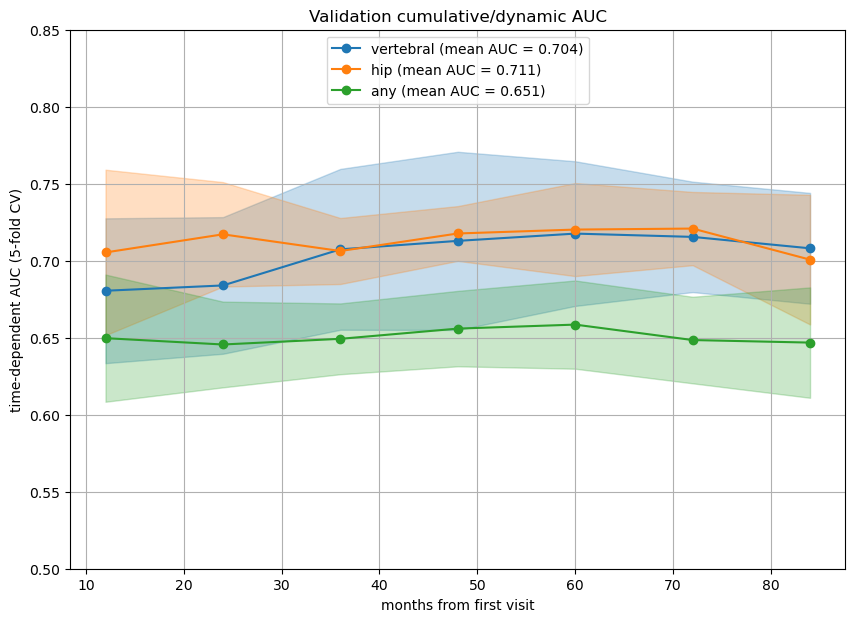

In [6]:
# Define times at which to measure AUC (every year)
times = np.arange(12, 95, 12)
time_to_evaluate = 24

# Setup dataframe to store statistics in
multi_index = pd.MultiIndex.from_tuples([(x, y) for x in ["vertebral", "hip", "any"] for y in ["train", "valid", "test"]])
df_stats = pd.DataFrame([], index=multi_index, columns=["harrel_global", "harrel_2y", "uno_2y", "auc_2y", "auc_mean"])

model_name = "rsf" 
cv = 5
kf = StratifiedKFold(n_splits=cv)
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
for i, fx in enumerate(FRACTURES):
    fx_type = fx.split("_")[0]
    print(fx_type)
    
    c_index_scores = {"train": {}, "valid": {}}
    auc_scores = {}
    for cv_index, (train_index, validation_index) in enumerate(kf.split(train_data, train_data.loc[:,"any_right_censored"])):
        # Prepare train and validation set
        train_prepped = prepare_data(train_data.loc[train_index,:], fx_type, only_first_visits=False)
        X_train, y_train, scaler = train_prepped["X"], train_prepped["y"], train_prepped["scaler"]
        valid_prepped = prepare_data(train_data.loc[validation_index,:], fx_type, scaler, only_first_visits=False)
        X_valid, y_valid = valid_prepped["X"], valid_prepped["y"]
        
        # Train model
        model = RandomSurvivalForest(
            n_estimators=best_params[fx_type]["n_estimators"],
            max_depth=best_params[fx_type]["max_depth"],
            min_samples_split=best_params[fx_type]["min_samples_split"],
            min_samples_leaf=best_params[fx_type]["min_samples_leaf"],
            n_jobs=4,
            random_state=123
        )
        model.fit(X_train, y_train)
        
        for tv in ["train", "valid"]:
            if tv == "train":
                X, y = X_train, y_train
            else:
                X, y = X_valid, y_valid
                
            # Compute cumlutaive hazard functions over time for each patient
            # They can be understood as our risk scores at a specific time
            chf_funcs = model.predict_cumulative_hazard_function(X, return_array=False)
            risk_scores = np.row_stack([chf(times) for chf in chf_funcs])
            
            # Censor events after time t
            y_censored = censor_after(y, time_to_evaluate)
            
            # Compute Harrel's and Uno's C-Index
            c_index_harrel_glob = model.score(X, y)
            c_index_harrel, _, _, _, _ = concordance_index_censored(y_censored["Event_observed"], y_censored["Survival_in_months"], [chf(time_to_evaluate) for chf in chf_funcs])
            c_index_uno, _, _, _, _ = concordance_index_ipcw(y_train, y_censored, [chf(time_to_evaluate) for chf in chf_funcs])
            c_index_scores[tv].setdefault(f"{fx_type}_harrel_global", list()).append(c_index_harrel_glob)
            c_index_scores[tv].setdefault(f"{fx_type}_harrel", list()).append(c_index_harrel)
            c_index_scores[tv].setdefault(f"{fx_type}_uno", list()).append(c_index_uno)

        # Compute cululative/dynamic AUC
        auc, mean_auc = cumulative_dynamic_auc(y_train, y_valid, risk_scores, times)
        auc_scores.setdefault(fx_type, list()).append(auc)
        auc_scores.setdefault(f"{fx_type}_mean", list()).append(mean_auc)
    
    # Print C-Index Scores
    df_stats = produce_stats(df_stats, c_index_scores, auc_scores, t=time_to_evaluate)
    
    # Plot the cumulative/dynamic AUC scores
    ax.plot(times, np.mean(auc_scores[fx_type], axis=0), "o-", label="{} (mean AUC = {:.3f})".format(fx_type, np.mean(auc_scores[f"{fx_type}_mean"])))
    
    # 95% confidence intervals
    #alpha = 0.95
    #lower = np.percentile(auc_scores[fx_type], ((1.0-alpha)/2.0) * 100, axis=0)
    #upper = np.percentile(auc_scores[fx_type], (alpha+((1.0-alpha)/2.0)) * 100, axis=0)
    
    yerr_neg = np.mean(auc_scores[fx_type], axis=0) - np.std(auc_scores[fx_type], axis=0)
    yerr_pos = np.mean(auc_scores[fx_type], axis=0) + np.std(auc_scores[fx_type], axis=0)
    ax.fill_between(times, yerr_neg, yerr_pos, color=f'C{i}', alpha=0.25)
    
    ax.set_title("Validation cumulative/dynamic AUC")
    ax.set_ylim(0.5, 0.85)
    ax.set_xlabel("months from first visit")
    ax.set_ylabel("time-dependent AUC (5-fold CV)")
    ax.legend(loc="upper center")
    ax.grid(True)
    print()

vertebral


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.6766, 'lower': 0.64, 'upper': 0.714}, 'harrel_2y': 0.6849, 'uno_2y': {'c-index': 0.6847, 'lower': 0.637, 'upper': 0.731}, 'auc': 0.7029, 'auc_mean': 0.7035}

hip


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.717, 'lower': 0.658, 'upper': 0.78}, 'harrel_2y': 0.7034, 'uno_2y': {'c-index': 0.7079, 'lower': 0.637, 'upper': 0.779}, 'auc': 0.7205, 'auc_mean': 0.7323}

any


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.6247, 'lower': 0.599, 'upper': 0.65}, 'harrel_2y': 0.6239, 'uno_2y': {'c-index': 0.6248, 'lower': 0.594, 'upper': 0.654}, 'auc': 0.6413, 'auc_mean': 0.6465}



harrel_global harrel_2y  uno_2y  auc_2y auc_mean
vertebral train        0.7685    0.7924  0.7922     NaN      NaN
          valid        0.6818    0.6714   0.671  0.6839    0.704
          test         0.6766    0.6849  0.6847  0.7029   0.7035
hip       train        0.8187    0.8407  0.8418     NaN      NaN
          valid        0.7027    0.7077  0.7078  0.7171   0.7114
          test          0.717    0.7034  0.7079  0.7205   0.7323
any       train        0.6762    0.6862  0.6855     NaN      NaN
          valid        0.6328    0.6337  0.6325  0.6456    0.651
          test         0.6247    0.6239  0.6248  0.6413   0.6465

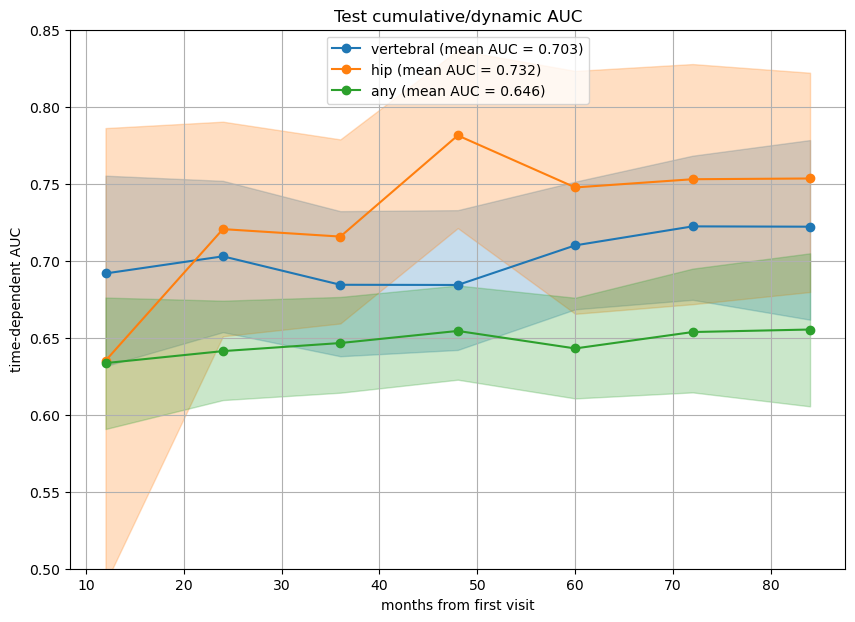

In [7]:
random.seed(99)
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
test_scores = {}
for i, fx in enumerate(FRACTURES):
    fx_type = fx.split("_")[0]
    print(fx_type)
    
    train_prepped = prepare_data(train_data, fx_type, only_first_visits=False)
    X_train, y_train = train_prepped["X"], train_prepped["y"]
    
    model = RandomSurvivalForest(
        n_estimators=best_params[fx_type]["n_estimators"],
        max_depth=best_params[fx_type]["max_depth"],
        min_samples_split=best_params[fx_type]["min_samples_split"],
        min_samples_leaf=best_params[fx_type]["min_samples_leaf"],
        n_jobs=4,
        random_state=123
    )
        
    # Train model
    model.fit(X_train, y_train)
    
    # Save model
    pickle.dump(model, open(f"models/rsf/{fx_type}.pkl", "wb"))    
    
    c_index_scores = {"harrel_global": [], "harrel_2y": [], "uno_2y": []}
    auc_scores = {"auc": [], "mean_auc": []}
    # Bootstrap test set with 1000 samples
    n_bootstrap = 1000
    for bootsrap_idx in tqdm(range(n_bootstrap)):
        bs_sample = test_data.copy()
        
        # Create bootstrap sample
        random.seed(bootsrap_idx)
        bs_index_list_stratified = provide_stratified_bootstap_sample_indices(bs_sample, fx_type)
        bs_sample = bs_sample.loc[bs_index_list_stratified , :]

        test_prepped = prepare_data(bs_sample, fx_type, only_first_visits=True)
        X_test, y_test = test_prepped["X"], test_prepped["y"]
                
        # Compute cumlutaive hazard functions over time for each patient
        # They can be understood as our risk scores at a specific time
        chf_funcs = model.predict_cumulative_hazard_function(X_test)
        risk_scores = [chf(TIME_TO_EVALUATE) for chf in chf_funcs]
    
        # Censor events after time t
        y_test_censored = censor_after(y_test, TIME_TO_EVALUATE)
            
        # Compute Harrel's and Uno's C-Index
        c_index_harrel_glob = model.score(X_test, y_test)
        c_index_harrel, _, _, _, _ = concordance_index_censored(y_test_censored["Event_observed"], y_test_censored["Survival_in_months"], risk_scores)
        c_index_uno, _, _, _, _ = concordance_index_ipcw(y_test, y_test_censored, risk_scores)
        c_index_scores["harrel_global"].append(c_index_harrel_glob)
        c_index_scores["harrel_2y"].append(c_index_harrel)
        c_index_scores["uno_2y"].append(c_index_uno)
        
        # Compute and plot cululative/dynamic AUC
        auc, mean_auc = cumulative_dynamic_auc(y_test, y_test, risk_scores, TIMES)
        auc_scores["auc"].append(auc)
        auc_scores["mean_auc"].append(mean_auc)
    
    # 95% confidence intervals
    harrel_lower, harrel_upper = get_confidence_interval(c_index_scores["harrel_global"], alpha=0.95, decimals=3)
    uno_lower, uno_upper = get_confidence_interval(c_index_scores["uno_2y"], alpha=0.95, decimals=3)
    test_scores[fx_type] = {
        "harrel_global": {
            "c-index": round(np.mean(c_index_scores["harrel_global"]), 4),
            "lower": harrel_lower,
            "upper": harrel_upper,
        },
        "harrel_2y": round(np.mean(c_index_scores["harrel_2y"]), 4),
        "uno_2y": {
            "c-index": round(np.mean(c_index_scores['uno_2y']), 4),
            "lower": uno_lower,
            "upper": uno_upper,
        },
        "auc": round(np.mean(auc_scores["auc"], axis=0)[(TIME_TO_EVALUATE // 12) - 1], 4),
        "auc_mean": round(np.mean(auc_scores["mean_auc"]), 4)
    }
    print(test_scores[fx_type])
    
    # Compute and plot cumulative/dynamic AUC
    ax.plot(TIMES, np.mean(auc_scores["auc"], axis=0), "o-", color=f'C{i}', label="{} (mean AUC = {:.3f})".format(fx_type, np.mean(auc_scores["mean_auc"])))
    
    # 95% confidence intervals
    lower, upper = get_confidence_interval(auc_scores["auc"], alpha=0.95, ax=0)
    ax.fill_between(TIMES, lower, upper, color=f'C{i}', alpha=0.25)
    
    ax.set_title("Test cumulative/dynamic AUC")
    ax.set_ylim(0.5, 0.85)
    ax.set_xlabel("months from first visit")
    ax.set_ylabel("time-dependent AUC")
    ax.legend(loc="upper center")
    ax.grid(True)
    
    # Add to df_stats
    df_stats.loc[(fx_type, "test"), "harrel_global"] = round(np.mean(c_index_scores["harrel_global"]), 4)
    df_stats.loc[(fx_type, "test"), "harrel_2y"] = round(np.mean(c_index_scores["harrel_2y"]), 4)
    df_stats.loc[(fx_type, "test"), "uno_2y"] = round(np.mean(c_index_scores['uno_2y']), 4)
    df_stats.loc[(fx_type, "test"), "auc_2y"] = round(np.mean(auc_scores["auc"], axis=0)[(TIME_TO_EVALUATE // 12) - 1], 4)
    df_stats.loc[(fx_type, "test"), "auc_mean"] = round(np.mean(auc_scores["mean_auc"]), 4)
    
    with open(f"results/c_index_scores/rsf/{fx_type}.json", "w") as f:
        json.dump(c_index_scores, f)
    
    print()

# Save test scores
with open("results/rsf_test_scores.json", "w") as f:
    json.dump(test_scores, f)

df_stats

## XGBoost AFT

In [8]:
# Load data
train_data = pd.read_csv("data/final/train.csv", parse_dates=["date"])
test_data = pd.read_csv("data/final/test.csv", parse_dates=["date"])

vertebral
------------- train -------------
Harrels C-Index (Global): 0.7541
Harrels C-Index (at t=24): 0.7618
Unos C-Index: 0.7596
------------- valid -------------
Harrels C-Index (Global): 0.6828
Harrels C-Index (at t=24): 0.6765
Unos C-Index: 0.6762
AUC at 2y: 0.6895
Mean AUC: 0.7101
hip
------------- train -------------
Harrels C-Index (Global): 0.8205
Harrels C-Index (at t=24): 0.826
Unos C-Index: 0.8263
------------- valid -------------
Harrels C-Index (Global): 0.7082
Harrels C-Index (at t=24): 0.7196
Unos C-Index: 0.7205
AUC at 2y: 0.7291
Mean AUC: 0.7206
any
------------- train -------------
Harrels C-Index (Global): 0.6839
Harrels C-Index (at t=24): 0.6909
Unos C-Index: 0.6896
------------- valid -------------
Harrels C-Index (Global): 0.6356
Harrels C-Index (at t=24): 0.6383
Unos C-Index: 0.6373
AUC at 2y: 0.6516
Mean AUC: 0.6636



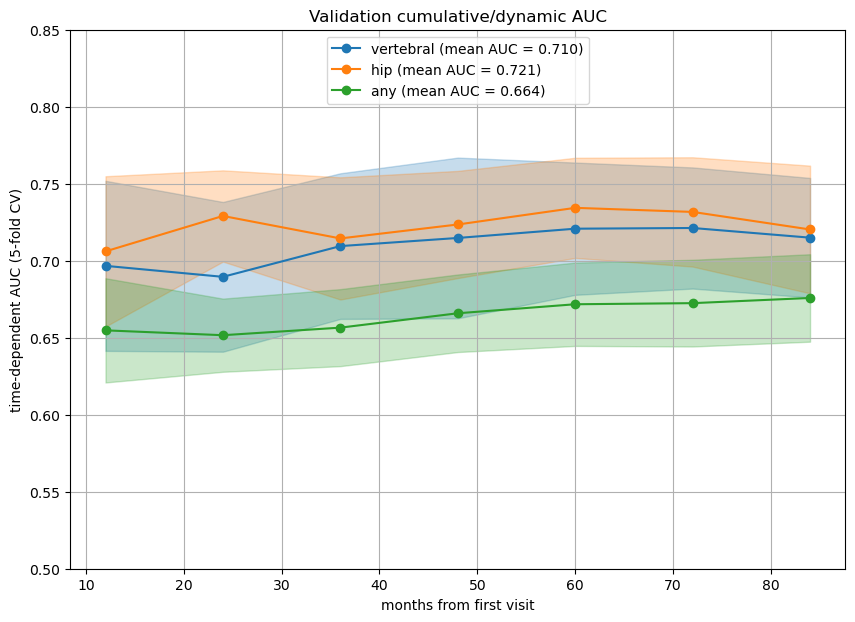

In [9]:
best_params = load_params(model="aft")
df_stats = train_model(train_data, best_params, t=TIME_TO_EVALUATE, times=TIMES, model_type="aft")

vertebral


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.6725, 'lower': 0.64, 'upper': 0.708}, 'harrel_2y': 0.6738, 'uno_2y': {'c-index': 0.672, 'lower': 0.629, 'upper': 0.717}, 'auc': 0.6888, 'auc_mean': 0.7017}

hip


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.7212, 'lower': 0.663, 'upper': 0.781}, 'harrel_2y': 0.709, 'uno_2y': {'c-index': 0.7138, 'lower': 0.645, 'upper': 0.785}, 'auc': 0.725, 'auc_mean': 0.752}

any


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.6193, 'lower': 0.596, 'upper': 0.643}, 'harrel_2y': 0.6117, 'uno_2y': {'c-index': 0.6131, 'lower': 0.584, 'upper': 0.643}, 'auc': 0.6307, 'auc_mean': 0.6521}



harrel_global harrel_2y  uno_2y  auc_2y auc_mean
vertebral train        0.7541    0.7618  0.7596     NaN      NaN
          valid        0.6828    0.6765  0.6762  0.6895   0.7101
          test         0.6725    0.6738   0.672  0.6888   0.7017
hip       train        0.8205     0.826  0.8263     NaN      NaN
          valid        0.7082    0.7196  0.7205  0.7291   0.7206
          test         0.7212     0.709  0.7138   0.725    0.752
any       train        0.6839    0.6909  0.6896     NaN      NaN
          valid        0.6356    0.6383  0.6373  0.6516   0.6636
          test         0.6193    0.6117  0.6131  0.6307   0.6521

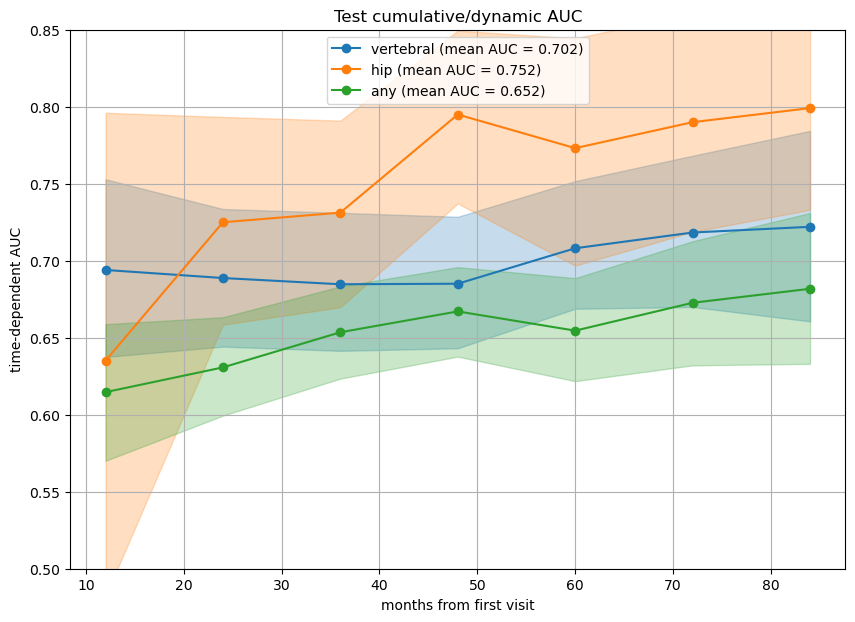

In [10]:
best_params = load_params(model="aft")
summary = test_model(
    train_data, test_data, best_params, TIME_TO_EVALUATE, TIMES, "aft", df_stats, 
    bootstrap=True,
    save_model_path="models", save_results_path="results"
)
summary["stats"]

## XGBoost AFT + constraints

vertebral
------------- train -------------
Harrels C-Index (Global): 0.7538
Harrels C-Index (at t=24): 0.7559
Unos C-Index: 0.7544
------------- valid -------------
Harrels C-Index (Global): 0.6813
Harrels C-Index (at t=24): 0.6763
Unos C-Index: 0.6753
AUC at 2y: 0.6891
Mean AUC: 0.7078
hip
------------- train -------------
Harrels C-Index (Global): 0.7645
Harrels C-Index (at t=24): 0.7818
Unos C-Index: 0.7809
------------- valid -------------
Harrels C-Index (Global): 0.7082
Harrels C-Index (at t=24): 0.7176
Unos C-Index: 0.7193
AUC at 2y: 0.7301
Mean AUC: 0.7235
any
------------- train -------------
Harrels C-Index (Global): 0.6894
Harrels C-Index (at t=24): 0.6966
Unos C-Index: 0.695
------------- valid -------------
Harrels C-Index (Global): 0.6368
Harrels C-Index (at t=24): 0.6375
Unos C-Index: 0.6365
AUC at 2y: 0.6499
Mean AUC: 0.6605



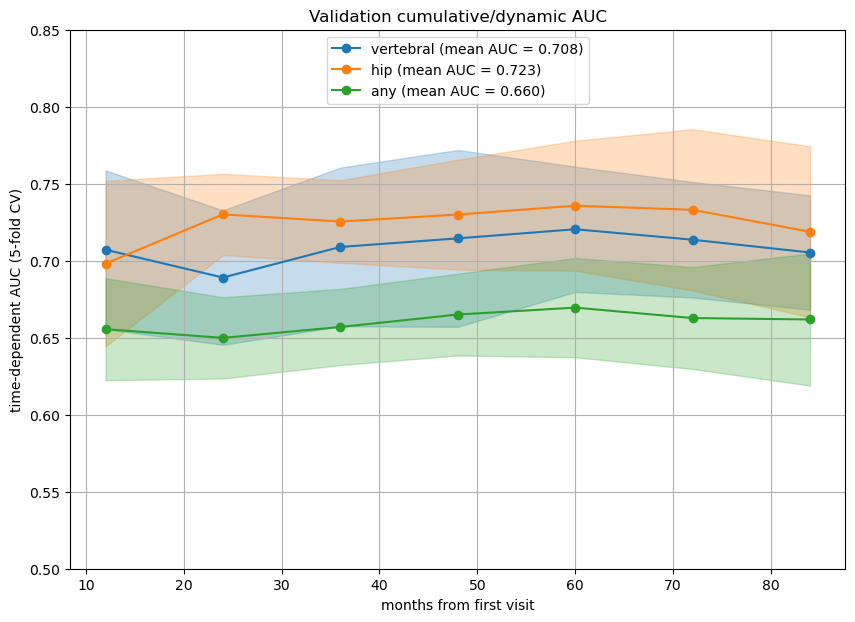

In [11]:
# Load data
train_data = pd.read_csv("data/final/train.csv", parse_dates=["date"])
test_data = pd.read_csv("data/final/test.csv", parse_dates=["date"])

best_params = load_params(model="aft", constraints=True)
df_stats = train_model(train_data, best_params, t=TIME_TO_EVALUATE, times=TIMES, model_type="aft")

vertebral
Created directory:  models/aft_mono


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.6779, 'lower': 0.646, 'upper': 0.711}, 'harrel_2y': 0.6862, 'uno_2y': {'c-index': 0.6853, 'lower': 0.643, 'upper': 0.728}, 'auc': 0.7064, 'auc_mean': 0.7048}

hip


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.7162, 'lower': 0.661, 'upper': 0.772}, 'harrel_2y': 0.7111, 'uno_2y': {'c-index': 0.7154, 'lower': 0.649, 'upper': 0.783}, 'auc': 0.7287, 'auc_mean': 0.7516}

any


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.626, 'lower': 0.602, 'upper': 0.651}, 'harrel_2y': 0.6249, 'uno_2y': {'c-index': 0.6263, 'lower': 0.595, 'upper': 0.658}, 'auc': 0.6461, 'auc_mean': 0.652}



harrel_global harrel_2y  uno_2y  auc_2y auc_mean
vertebral train        0.7538    0.7559  0.7544     NaN      NaN
          valid        0.6813    0.6763  0.6753  0.6891   0.7078
          test         0.6779    0.6862  0.6853  0.7064   0.7048
hip       train        0.7645    0.7818  0.7809     NaN      NaN
          valid        0.7082    0.7176  0.7193  0.7301   0.7235
          test         0.7162    0.7111  0.7154  0.7287   0.7516
any       train        0.6894    0.6966   0.695     NaN      NaN
          valid        0.6368    0.6375  0.6365  0.6499   0.6605
          test          0.626    0.6249  0.6263  0.6461    0.652

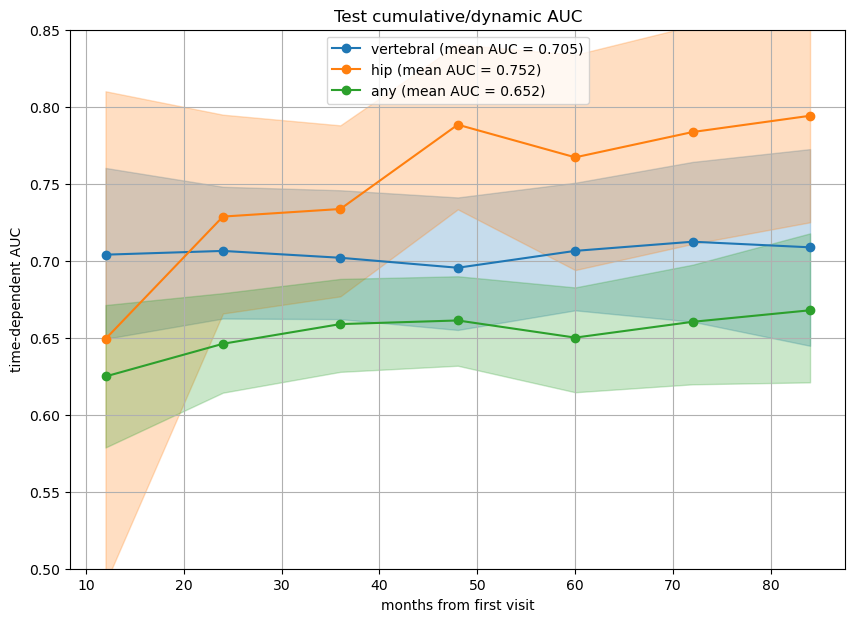

In [12]:
best_params = load_params(model="aft", constraints=True)
summary = test_model(
    train_data, test_data, best_params, TIME_TO_EVALUATE, TIMES, "aft_mono", df_stats, 
    save_model_path="models", save_results_path="results", bootstrap=True
)
summary["stats"]

## XGBoost Cox

vertebral
------------- train -------------
Harrels C-Index (Global): 0.8065
Harrels C-Index (at t=24): 0.8038
Unos C-Index: 0.8034
------------- valid -------------
Harrels C-Index (Global): 0.6877
Harrels C-Index (at t=24): 0.6819
Unos C-Index: 0.6815
AUC at 2y: 0.6945
Mean AUC: 0.718
hip
------------- train -------------
Harrels C-Index (Global): 0.8587
Harrels C-Index (at t=24): 0.8609
Unos C-Index: 0.8607
------------- valid -------------
Harrels C-Index (Global): 0.7144
Harrels C-Index (at t=24): 0.7273
Unos C-Index: 0.7284
AUC at 2y: 0.7372
Mean AUC: 0.7258
any
------------- train -------------
Harrels C-Index (Global): 0.6826
Harrels C-Index (at t=24): 0.683
Unos C-Index: 0.6826
------------- valid -------------
Harrels C-Index (Global): 0.6374
Harrels C-Index (at t=24): 0.6391
Unos C-Index: 0.6383
AUC at 2y: 0.6516
Mean AUC: 0.6633



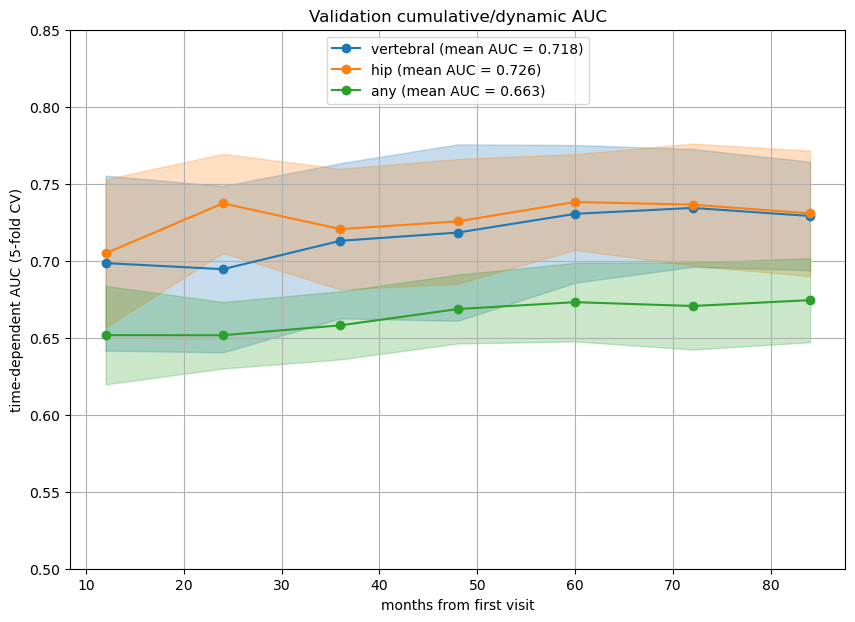

In [13]:
# Load data
train_data = pd.read_csv("data/final/train.csv", parse_dates=["date"])
test_data = pd.read_csv("data/final/test.csv", parse_dates=["date"])

best_params = load_params(model="cox")
df_stats = train_model(train_data, best_params, t=TIME_TO_EVALUATE, times=TIMES, model_type="cox")

vertebral


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.6857, 'lower': 0.652, 'upper': 0.719}, 'harrel_2y': 0.689, 'uno_2y': {'c-index': 0.6865, 'lower': 0.642, 'upper': 0.729}, 'auc': 0.7023, 'auc_mean': 0.7199}

hip


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.7158, 'lower': 0.657, 'upper': 0.776}, 'harrel_2y': 0.6992, 'uno_2y': {'c-index': 0.7046, 'lower': 0.634, 'upper': 0.777}, 'auc': 0.7172, 'auc_mean': 0.7511}

any


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.6225, 'lower': 0.599, 'upper': 0.648}, 'harrel_2y': 0.6161, 'uno_2y': {'c-index': 0.6174, 'lower': 0.588, 'upper': 0.649}, 'auc': 0.6345, 'auc_mean': 0.6495}



harrel_global harrel_2y  uno_2y  auc_2y auc_mean
vertebral train        0.8065    0.8038  0.8034     NaN      NaN
          valid        0.6877    0.6819  0.6815  0.6945    0.718
          test         0.6857     0.689  0.6865  0.7023   0.7199
hip       train        0.8587    0.8609  0.8607     NaN      NaN
          valid        0.7144    0.7273  0.7284  0.7372   0.7258
          test         0.7158    0.6992  0.7046  0.7172   0.7511
any       train        0.6826     0.683  0.6826     NaN      NaN
          valid        0.6374    0.6391  0.6383  0.6516   0.6633
          test         0.6225    0.6161  0.6174  0.6345   0.6495

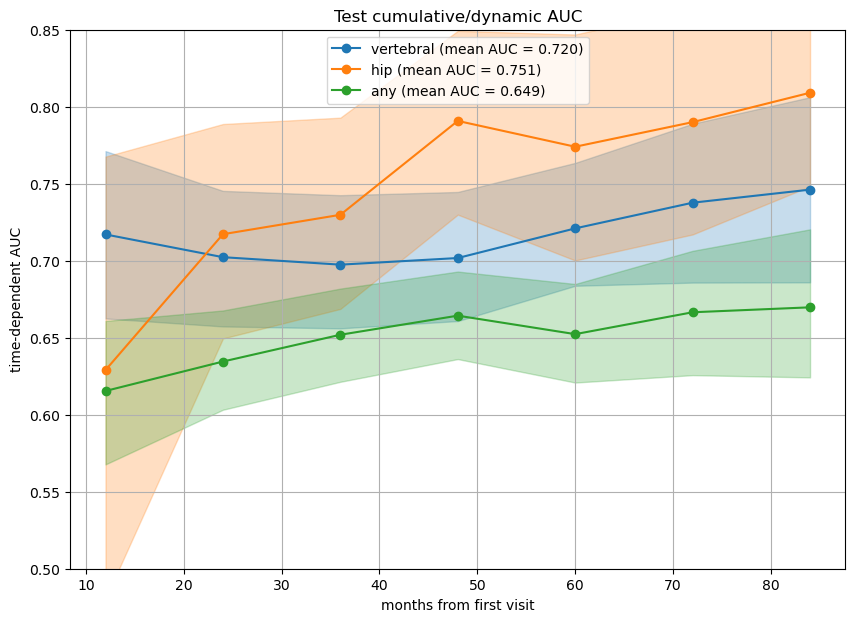

In [14]:
best_params = load_params(model="cox")
summary = test_model(
    train_data, test_data, best_params, TIME_TO_EVALUATE, TIMES, "cox", df_stats, 
    save_model_path="models", save_results_path="results", bootstrap=True
)
summary["stats"]

## XGBoost Cox + constraints

vertebral
------------- train -------------
Harrels C-Index (Global): 0.7846
Harrels C-Index (at t=24): 0.7806
Unos C-Index: 0.7797
------------- valid -------------
Harrels C-Index (Global): 0.6905
Harrels C-Index (at t=24): 0.6846
Unos C-Index: 0.6846
AUC at 2y: 0.6973
Mean AUC: 0.7178
hip
------------- train -------------
Harrels C-Index (Global): 0.8463
Harrels C-Index (at t=24): 0.8478
Unos C-Index: 0.8479
------------- valid -------------
Harrels C-Index (Global): 0.7133
Harrels C-Index (at t=24): 0.7208
Unos C-Index: 0.7223
AUC at 2y: 0.7315
Mean AUC: 0.7237
any
------------- train -------------
Harrels C-Index (Global): 0.7087
Harrels C-Index (at t=24): 0.7089
Unos C-Index: 0.7085
------------- valid -------------
Harrels C-Index (Global): 0.642
Harrels C-Index (at t=24): 0.6428
Unos C-Index: 0.642
AUC at 2y: 0.6564
Mean AUC: 0.67



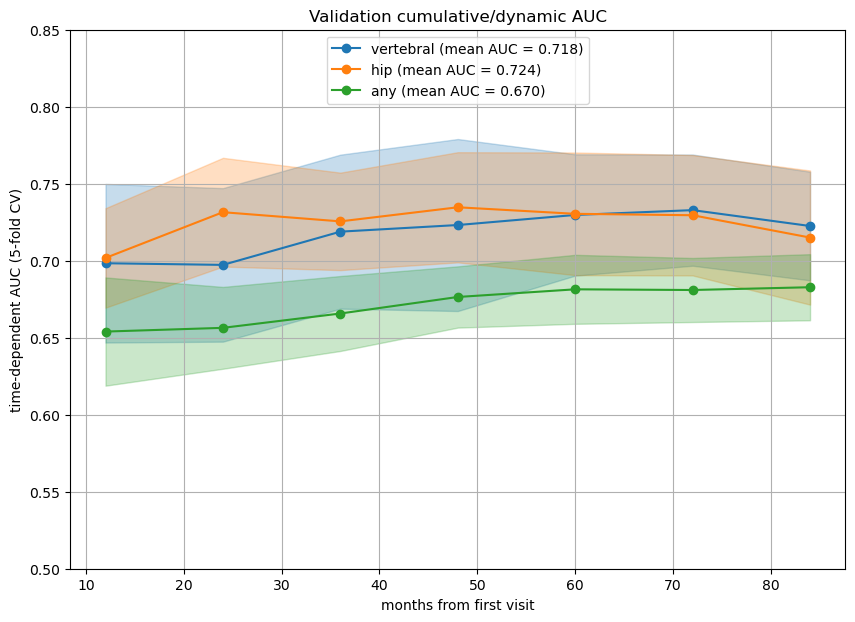

In [15]:
# Load data
train_data = pd.read_csv("data/final/train.csv", parse_dates=["date"])
test_data = pd.read_csv("data/final/test.csv", parse_dates=["date"])

best_params = load_params(model="cox", constraints=True)
df_stats = train_model(train_data, best_params, t=TIME_TO_EVALUATE, times=TIMES, model_type="cox")

vertebral
Created directory:  models/cox_mono


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.6798, 'lower': 0.645, 'upper': 0.714}, 'harrel_2y': 0.6847, 'uno_2y': {'c-index': 0.6822, 'lower': 0.637, 'upper': 0.728}, 'auc': 0.6997, 'auc_mean': 0.7091}

hip


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.7195, 'lower': 0.661, 'upper': 0.775}, 'harrel_2y': 0.7122, 'uno_2y': {'c-index': 0.7158, 'lower': 0.646, 'upper': 0.786}, 'auc': 0.7287, 'auc_mean': 0.7522}

any


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.6206, 'lower': 0.596, 'upper': 0.646}, 'harrel_2y': 0.6162, 'uno_2y': {'c-index': 0.6174, 'lower': 0.587, 'upper': 0.65}, 'auc': 0.6364, 'auc_mean': 0.648}



harrel_global harrel_2y  uno_2y  auc_2y auc_mean
vertebral train        0.7846    0.7806  0.7797     NaN      NaN
          valid        0.6905    0.6846  0.6846  0.6973   0.7178
          test         0.6798    0.6847  0.6822  0.6997   0.7091
hip       train        0.8463    0.8478  0.8479     NaN      NaN
          valid        0.7133    0.7208  0.7223  0.7315   0.7237
          test         0.7195    0.7122  0.7158  0.7287   0.7522
any       train        0.7087    0.7089  0.7085     NaN      NaN
          valid         0.642    0.6428   0.642  0.6564     0.67
          test         0.6206    0.6162  0.6174  0.6364    0.648

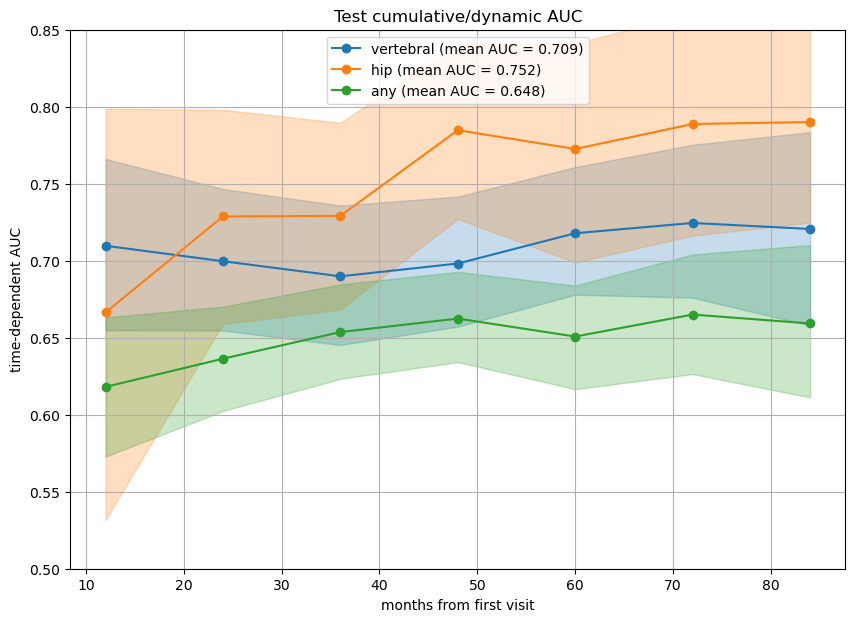

In [16]:
best_params = load_params(model="cox", constraints=True)
summary = test_model(
    train_data, test_data, best_params, TIME_TO_EVALUATE, TIMES, "cox_mono", df_stats, 
    save_model_path="models/xgb", save_results_path="results", bootstrap=True
)
summary["stats"]

## Results

Finally, the best model for each of the categories by Uno's C-index at 2 years (uno_2y) are:

**Vertebral fracture**
* Model: XGBoost-Cox
* Test-Score: 0.6865 [0.642, 0.729]

**Hip fracture**
* Model: XGBoost-Cox-mono
* Test-Score: 0.7158 [0.646, 0.786]

**Any fracture**
* Model: XGBoost-AFT-mono
* Test-Score: 0.6263 [0.595, 0.658]

Now, we are going to copy the best models to the directory `models/` and save the results in the directory `results/`.

In [17]:
import shutil

# create new directory models/xgb
if not os.path.exists("models/xgb"):
    os.mkdir("models/xgb")
    print("Created directory: models/xgb")
    
# copy best model configuration files to models/xgb
shutil.copyfile("models/xgb_cox/vertebral.json", "models/xgb/vertebral.json")
shutil.copyfile("models/xgb_cox_mono/hip.json", "models/xgb/hip.json")
shutil.copyfile("models/xgb_aft_mono/any.json", "models/xgb/any.json")

Created directory: models/xgb


'models/xgb/any.json'

In [18]:
test_scores = {}

with open("results/xgb_cox_test_scores.json", "r") as file:
    cox_test_scores = json.load(file)
    test_scores["vertebral"] = cox_test_scores["vertebral"]

with open("results/xgb_cox_mono_test_scores.json", "r") as file:
    cox_mono_test_scores = json.load(file)
    test_scores["hip"] = cox_mono_test_scores["hip"]
    
with open("results/xgb_aft_mono_test_scores.json", "r") as file:
    aft_mono_test_scores = json.load(file)
    test_scores["any"] = aft_mono_test_scores["any"]
    
# Save test scores
with open("results/xgb_test_scores.json", "w") as file:
    json.dump(test_scores, file)

In [19]:
c_index_scores = {}

with open("results/c_index_scores/xgb/cox_vertebral.json", "r") as file:
    c_index_scores["vertebral"] = json.load(file)

with open("results/c_index_scores/xgb/cox_mono_hip.json", "r") as file:
    c_index_scores["hip"] = json.load(file)
    
with open("results/c_index_scores/xgb/aft_mono_any.json", "r") as file:
    c_index_scores["any"] = json.load(file)

# Save c-index scores
with open("results/c_index_scores/xgb.json", "w") as file:
    json.dump(c_index_scores, file)

# FRAX scores

Finally, we wanted to find out how well the FRAX algorithm performs on the test set. The FRAX scores are saved in the directory `data/FRAX/`.  

In [11]:
# Load testset
df_test = pd.read_csv("data/final/test.csv", parse_dates=["date"])
df_test = df_test.groupby("patientId").first().reset_index()
df_test = df_test[df_test["postmenopausal"] == 1]
df_test = df_test.dropna()
df_test

,patientId,centerId,date,postmenopausal,praemenopausal,hrt,height,weight,bmi,hip_fracture_parents,...,previous_fracture,num_visits,tscore_ls,tscore_neck,tscore_totalHip,tbs_ls,tscore_ls_imputed,tscore_neck_imputed,tscore_totalHip_imputed,tbs_ls_imputed
0,3,8,2018-06-13,1.0,0.0,0.0,153.0,68.1,29.1,0.0,...,1.0,1.0,-2.6,-2.300000,-2.000000,1.169,0.0,0.0,0.0,0.0
2,17,8,2018-08-27,1.0,0.0,0.0,164.0,78.0,29.0,0.0,...,0.0,1.0,-1.8,-1.600000,-1.500000,1.118,0.0,0.0,0.0,0.0
3,20,8,2018-08-29,1.0,0.0,0.0,159.0,47.4,18.7,0.0,...,0.0,1.0,-2.2,-1.700000,-0.800000,1.402,0.0,0.0,0.0,0.0
4,24,8,2020-11-11,1.0,0.0,0.0,163.8,65.2,24.3,0.0,...,1.0,1.0,-1.3,-1.600000,-1.100000,1.499,0.0,0.0,0.0,0.0
5,30,8,2020-11-09,1.0,0.0,0.0,177.0,85.0,27.1,0.0,...,2.0,2.0,-1.0,-1.904807,-1.668246,1.342,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,18760,2,2016-04-12,1.0,0.0,0.0,156.0,82.0,33.7,1.0,...,1.0,1.0,-1.5,-0.900000,0.200000,1.369,0.0,0.0,0.0,0.0
1977,18763,2,2019-10-07,1.0,0.0,0.0,163.0,45.0,16.9,0.0,...,0.0,2.0,-2.9,-2.600000,-2.300000,1.341,0.0,0.0,0.0,0.0
1979,19064,28,2019-04-12,1.0,0.0,0.0,155.0,54.0,22.5,0.0,...,0.0,2.0,0.1,-3.400000,-1.800000,1.300,0.0,0.0,0.0,1.0
1987,19583,2,2022-04-19,1.0,0.0,0.0,149.0,68.0,30.6,0.0,...,2.0,1.0,-2.0,-2.900000,-3.100000,1.166,0.0,0.0,0.0,0.0


In [12]:
# Load FRAX scores
df_risks = pd.read_csv("data/FRAX/fracture_risks.csv", parse_dates=["date"]).loc[:,:"risk_hip"]
df_risks.rename(columns={"10_j_frakturrisiko": "TOP_risk_mof"}, inplace=True)
df_risks

,patientId,date,TOP_risk_mof,risk_mof,risk_hip
0,1,2018-06-01,10.9,NaN,NaN
1,1,2020-10-23,12.7,NaN,NaN
2,2,2018-06-06,10.9,NaN,NaN
3,2,2020-10-01,11.2,NaN,NaN
4,3,2018-06-13,34.6,33.0,10.0
...,...,...,...,...,...
32464,20004,2022-06-03,39.2,30.0,11.0
32465,20005,2022-06-03,4.7,NaN,NaN
32466,20006,2022-06-03,18.2,17.0,1.8
32467,20007,2022-06-03,3.7,4.2,0.3


In [13]:
# join the two tables
fracture_risks = df_test.set_index(["patientId", "date"]).join(df_risks.set_index(["patientId", "date"]), how="left")
fracture_risks = fracture_risks.reset_index()
fracture_risks

,patientId,date,centerId,postmenopausal,praemenopausal,hrt,height,weight,bmi,hip_fracture_parents,...,tscore_neck,tscore_totalHip,tbs_ls,tscore_ls_imputed,tscore_neck_imputed,tscore_totalHip_imputed,tbs_ls_imputed,TOP_risk_mof,risk_mof,risk_hip
0,3,2018-06-13,8,1.0,0.0,0.0,153.0,68.1,29.1,0.0,...,-2.300000,-2.000000,1.169,0.0,0.0,0.0,0.0,34.6,33.0,10.0
1,17,2018-08-27,8,1.0,0.0,0.0,164.0,78.0,29.0,0.0,...,-1.600000,-1.500000,1.118,0.0,0.0,0.0,0.0,35.4,19.0,4.0
2,20,2018-08-29,8,1.0,0.0,0.0,159.0,47.4,18.7,0.0,...,-1.700000,-0.800000,1.402,0.0,0.0,0.0,0.0,16.9,7.0,1.5
3,24,2020-11-11,8,1.0,0.0,0.0,163.8,65.2,24.3,0.0,...,-1.600000,-1.100000,1.499,0.0,0.0,0.0,0.0,19.9,13.0,1.6
4,30,2020-11-09,8,1.0,0.0,0.0,177.0,85.0,27.1,0.0,...,-1.904807,-1.668246,1.342,0.0,1.0,1.0,0.0,23.7,60.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845,18760,2016-04-12,2,1.0,0.0,0.0,156.0,82.0,33.7,1.0,...,-0.900000,0.200000,1.369,0.0,0.0,0.0,0.0,23.2,23.0,0.7
1846,18763,2019-10-07,2,1.0,0.0,0.0,163.0,45.0,16.9,0.0,...,-2.600000,-2.300000,1.341,0.0,0.0,0.0,0.0,14.1,12.0,3.4
1847,19064,2019-04-12,28,1.0,0.0,0.0,155.0,54.0,22.5,0.0,...,-3.400000,-1.800000,1.300,0.0,0.0,0.0,1.0,23.8,36.0,16.0
1848,19583,2022-04-19,2,1.0,0.0,0.0,149.0,68.0,30.6,0.0,...,-2.900000,-3.100000,1.166,0.0,0.0,0.0,0.0,46.0,30.0,14.0


In [14]:
fracture_risks["hip_right_censored"] = fracture_risks["hip_right_censored"].apply(lambda x: int(not x))
fracture_risks["any_right_censored"] = fracture_risks["any_right_censored"].apply(lambda x: int(not x))

In [16]:
frax_risks = fracture_risks[["hip_fracture", "any_fracture", "hip_right_censored", "any_right_censored", "risk_hip", "risk_mof"]].dropna()
top_risks = fracture_risks[["hip_fracture", "any_fracture", "hip_right_censored", "any_right_censored", "TOP_risk_mof"]].dropna()
display(frax_risks)
top_risks

,hip_fracture,any_fracture,hip_right_censored,any_right_censored,risk_hip,risk_mof
0,27.574,27.574,0,0,10.0,33.0
1,23.869,23.869,0,0,4.0,19.0
2,26.623,26.623,0,0,1.5,7.0
3,22.131,22.131,0,1,1.6,13.0
4,24.131,24.131,0,0,39.0,60.0
...,...,...,...,...,...,...
1845,69.770,69.770,0,0,0.7,23.0
1846,28.033,28.033,0,0,3.4,12.0
1847,0.426,0.426,0,0,16.0,36.0
1848,0.033,0.033,0,1,14.0,30.0


,hip_fracture,any_fracture,hip_right_censored,any_right_censored,TOP_risk_mof
0,27.574,27.574,0,0,34.6
1,23.869,23.869,0,0,35.4
2,26.623,26.623,0,0,16.9
3,22.131,22.131,0,1,19.9
4,24.131,24.131,0,0,23.7
...,...,...,...,...,...
1845,69.770,69.770,0,0,23.2
1846,28.033,28.033,0,0,14.1
1847,0.426,0.426,0,0,23.8
1848,0.033,0.033,0,1,46.0


In [20]:
def censor_after(y, t=24):
    y_copy = y.copy()
    larger_than_t = (y_copy["Survival_in_months"] > t)
    y_copy["Event_observed"][larger_than_t] = 0
    return y_copy


def reshape_y(df_risks, fx_type, censored=False):
    y = pd.DataFrame({
        "Event_observed": df_risks[f"{fx_type}_right_censored"],
        "Survival_in_months": df_risks[f"{fx_type}_fracture"]
    })
    y = [(e1, e2) for e1, e2 in y.to_numpy()]
    y = np.array(y, dtype=[("Event_observed", "?"), ("Survival_in_months", "<f8")])
    if censored:
        return censor_after(y, t=24)
    return y

In [18]:
# we also need to load and prepare the training data to calculate Uno's C-Index
train_data = pd.read_csv("data/final/train.csv", parse_dates=["date"])
train_data = train_data[train_data["postmenopausal"] == 1]
train_data = train_data.dropna()
y_train = train_data.loc[:, ["hip_fracture", "any_fracture", "hip_right_censored", "any_right_censored"]].dropna()
y_train["hip_right_censored"] = y_train[f"hip_right_censored"].apply(lambda x: int(not x))
y_train["any_right_censored"] = y_train[f"any_right_censored"].apply(lambda x: int(not x))
y_train

,hip_fracture,any_fracture,hip_right_censored,any_right_censored
0,36.656,36.656,0,0
1,61.180,32.230,0,1
2,8.230,8.230,0,0
3,23.738,23.738,0,0
4,85.705,85.705,0,0
...,...,...,...,...
9294,26.820,26.820,0,0
9295,59.967,59.967,0,0
9297,26.066,26.066,0,0
9298,24.492,24.492,0,0


In [24]:
bootstrap = True
random.seed(99)

y_risks_train_any = reshape_y(y_train, "any")

c_index_scores = {"harrel_global": [], "harrel_2y": [], "uno_2y": []}
if bootstrap:
    # Bootstrap test set with 1000 samples
    n_bootstrap = 1000
    for bootsrap_idx in tqdm(range(n_bootstrap)):
        bs_sample = frax_risks.copy()
        
        # Create bootstrap sample
        bs_index_list_stratified = provide_stratified_bootstap_sample_indices(bs_sample, "any")
        bs_sample = bs_sample.loc[bs_index_list_stratified , :]

        y_risks_any = reshape_y(bs_sample, "any")
        y_risks_any_censored = reshape_y(bs_sample, "any", censored=True)

        c_index_harrel_glob, _, _, _, _ = concordance_index_censored(y_risks_any["Event_observed"], y_risks_any["Survival_in_months"], bs_sample["risk_mof"])
        c_index_harrel, _, _, _, _ = concordance_index_censored(y_risks_any_censored["Event_observed"], y_risks_any_censored["Survival_in_months"], bs_sample["risk_mof"])
        c_index_uno, _, _, _, _ = concordance_index_ipcw(y_risks_train_any, y_risks_any_censored, bs_sample["risk_mof"])
        
        c_index_scores["harrel_global"].append(c_index_harrel_glob)
        c_index_scores["harrel_2y"].append(c_index_harrel)
        c_index_scores["uno_2y"].append(c_index_uno)

    harrel_lower, harrel_upper = get_confidence_interval(c_index_scores["harrel_global"], alpha=0.95, decimals=3)
    uno_lower, uno_upper = get_confidence_interval(c_index_scores["uno_2y"], alpha=0.95, decimals=3)

    print("Any Harrel C-Index (global):", {
                "c-index": round(np.mean(c_index_scores['harrel_global']), 4),
                "lower": harrel_lower,
                "upper": harrel_upper,
            })
    print("Any Harrel C-Index (t=2y):", round(np.mean(c_index_scores["harrel_2y"]), 4))
    print("Any Uno C-Index (t=2y):", {
                "c-index": round(np.mean(c_index_scores['uno_2y']), 4),
                "lower": uno_lower,
                "upper": uno_upper,
            })
    with open(f"results/c_index_scores/frax_mof.json", "w") as f:
        json.dump(c_index_scores, f)
else:
    y_risks_any = reshape_y(frax_risks, "any")
    y_risks_any_censored = reshape_y(frax_risks, "any", censored=True)

    c_index_harrel_glob, _, _, _, _ = concordance_index_censored(y_risks_any["Event_observed"], y_risks_any["Survival_in_months"], frax_risks["risk_mof"])
    c_index_harrel, _, _, _, _ = concordance_index_censored(y_risks_any_censored["Event_observed"], y_risks_any_censored["Survival_in_months"], frax_risks["risk_mof"])
    c_index_uno, _, _, _, _ = concordance_index_ipcw(y_risks_train_any, y_risks_any_censored, frax_risks["risk_mof"])
    
    print("FRAX MOF Harrel C-Index (global):", round(c_index_harrel_glob, 4))
    print("FRAX MOF Harrel C-Index (t=2y):", round(c_index_harrel, 4))
    print("FRAX MOF Uno C-Index (t=2y):", round(c_index_uno, 4))

  0%|          | 0/1000 [00:00<?, ?it/s]

Any Harrel C-Index (global): {'c-index': 0.5984, 'lower': 0.56, 'upper': 0.635}
Any Harrel C-Index (t=2y): 0.5972
Any Uno C-Index (t=2y): {'c-index': 0.5983, 'lower': 0.548, 'upper': 0.644}


In [25]:
# Set seed for bootstrapping
random.seed(99)

y_risks_train_any = reshape_y(y_train, "hip")

c_index_scores = {"harrel_global": [], "harrel_2y": [], "uno_2y": []}
if bootstrap:
    # Bootstrap test set with 1000 samples
    n_bootstrap = 1000
    for bootsrap_idx in tqdm(range(n_bootstrap)):
        bs_sample = frax_risks.copy()
        
        # Create bootstrap sample
        bs_index_list_stratified = provide_stratified_bootstap_sample_indices(bs_sample, "hip")
        bs_sample = bs_sample.loc[bs_index_list_stratified , :]

        y_risks_any = reshape_y(bs_sample, "hip")
        y_risks_any_censored = reshape_y(bs_sample, "hip", censored=True)

        c_index_harrel_glob, _, _, _, _ = concordance_index_censored(y_risks_any["Event_observed"], y_risks_any["Survival_in_months"], bs_sample["risk_hip"])
        c_index_harrel, _, _, _, _ = concordance_index_censored(y_risks_any_censored["Event_observed"], y_risks_any_censored["Survival_in_months"], bs_sample["risk_hip"])
        c_index_uno, _, _, _, _ = concordance_index_ipcw(y_risks_train_any, y_risks_any_censored, bs_sample["risk_hip"])
        
        c_index_scores["harrel_global"].append(c_index_harrel_glob)
        c_index_scores["harrel_2y"].append(c_index_harrel)
        c_index_scores["uno_2y"].append(c_index_uno)

    harrel_lower, harrel_upper = get_confidence_interval(c_index_scores["harrel_global"], alpha=0.95, decimals=3)
    uno_lower, uno_upper = get_confidence_interval(c_index_scores["uno_2y"], alpha=0.95, decimals=3)

    print("FRAX Hip Harrel C-Index (global):", {
                "c-index": round(np.mean(c_index_scores['harrel_global']), 4),
                "lower": harrel_lower,
                "upper": harrel_upper,
            })
    print("FRAX Hip Harrel C-Index (t=2y):", round(np.mean(c_index_scores["harrel_2y"]), 4))
    print("FRAX Hip Uno C-Index (t=2y):", {
                "c-index": round(np.mean(c_index_scores['uno_2y']), 4),
                "lower": uno_lower,
                "upper": uno_upper,
            })

    with open(f"results/c_index_scores/frax_hip.json", "w") as f:
        json.dump(c_index_scores, f)
else:
    y_risks_any = reshape_y(frax_risks, "hip")
    y_risks_any_censored = reshape_y(frax_risks, "hip", censored=True)

    c_index_harrel_glob, _, _, _, _ = concordance_index_censored(y_risks_any["Event_observed"], y_risks_any["Survival_in_months"], frax_risks["risk_hip"])
    c_index_harrel, _, _, _, _ = concordance_index_censored(y_risks_any_censored["Event_observed"], y_risks_any_censored["Survival_in_months"], frax_risks["risk_hip"])
    c_index_uno, _, _, _, _ = concordance_index_ipcw(y_risks_train_any, y_risks_any_censored, frax_risks["risk_hip"])
    
    print("FRAX hip Harrel C-Index (global):", round(c_index_harrel_glob, 4))
    print("FRAX hip Harrel C-Index (t=2y):", round(c_index_harrel, 4))
    print("FRAX hip Uno C-Index (t=2y):", round(c_index_uno, 4))

  0%|          | 0/1000 [00:00<?, ?it/s]

FRAX Hip Harrel C-Index (global): {'c-index': 0.6405, 'lower': 0.534, 'upper': 0.742}
FRAX Hip Harrel C-Index (t=2y): 0.6163
FRAX Hip Uno C-Index (t=2y): {'c-index': 0.6206, 'lower': 0.491, 'upper': 0.743}


### Scores of the TOP model

In [26]:
# Set seed for bootstrapping
random.seed(99)

y_risks_train_any = reshape_y(y_train, "any")

c_index_scores = {"harrel_global": [], "harrel_2y": [], "uno_2y": []}
if bootstrap:
    # Bootstrap test set with 1000 samples
    n_bootstrap = 1000
    for bootsrap_idx in tqdm(range(n_bootstrap)):
        bs_sample = top_risks.copy()
        
        # Create bootstrap sample
        bs_index_list_stratified = provide_stratified_bootstap_sample_indices(bs_sample, "any")
        bs_sample = bs_sample.loc[bs_index_list_stratified , :]

        y_risks_any = reshape_y(bs_sample, "any")
        y_risks_any_censored = reshape_y(bs_sample, "any", censored=True)

        c_index_harrel_glob, _, _, _, _ = concordance_index_censored(y_risks_any["Event_observed"], y_risks_any["Survival_in_months"], bs_sample["TOP_risk_mof"])
        c_index_harrel, _, _, _, _ = concordance_index_censored(y_risks_any_censored["Event_observed"], y_risks_any_censored["Survival_in_months"], bs_sample["TOP_risk_mof"])
        c_index_uno, _, _, _, _ = concordance_index_ipcw(y_risks_train_any, y_risks_any_censored, bs_sample["TOP_risk_mof"])
        
        c_index_scores["harrel_global"].append(c_index_harrel_glob)
        c_index_scores["harrel_2y"].append(c_index_harrel)
        c_index_scores["uno_2y"].append(c_index_uno)

    harrel_lower, harrel_upper = get_confidence_interval(c_index_scores["harrel_global"], alpha=0.95, decimals=3)
    uno_lower, uno_upper = get_confidence_interval(c_index_scores["uno_2y"], alpha=0.95, decimals=3)

    print("TOP MOF Performance")
    print("Any Harrel C-Index (global):", {
                "c-index": round(np.mean(c_index_scores['harrel_global']), 4),
                "lower": harrel_lower,
                "upper": harrel_upper,
            })
    print("Any Harrel C-Index (t=2y):", round(np.mean(c_index_scores["harrel_2y"]), 4))
    print("Any Uno C-Index (t=2y):", {
                "c-index": round(np.mean(c_index_scores['uno_2y']), 4),
                "lower": uno_lower,
                "upper": uno_upper,
            })

    with open(f"results/c_index_scores/top_mof.json", "w") as f:
        json.dump(c_index_scores, f)
else:
    y_risks_any = reshape_y(top_risks, "any")
    y_risks_any_censored = reshape_y(top_risks, "any", censored=True)

    c_index_harrel_glob, _, _, _, _ = concordance_index_censored(y_risks_any["Event_observed"], y_risks_any["Survival_in_months"], top_risks["TOP_risk_mof"])
    c_index_harrel, _, _, _, _ = concordance_index_censored(y_risks_any_censored["Event_observed"], y_risks_any_censored["Survival_in_months"], top_risks["TOP_risk_mof"])
    c_index_uno, _, _, _, _ = concordance_index_ipcw(y_risks_train_any, y_risks_any_censored, top_risks["TOP_risk_mof"])
    
    print("TOP MOF Harrel C-Index (global):", round(c_index_harrel_glob, 4))
    print("TOP MOF Harrel C-Index (t=2y):", round(c_index_harrel, 4))
    print("TOP MOF Uno C-Index (t=2y):", round(c_index_uno, 4))

  0%|          | 0/1000 [00:00<?, ?it/s]

TOP MOF Performance
Any Harrel C-Index (global): {'c-index': 0.5984, 'lower': 0.561, 'upper': 0.639}
Any Harrel C-Index (t=2y): 0.606
Any Uno C-Index (t=2y): {'c-index': 0.6073, 'lower': 0.559, 'upper': 0.657}


# P value Calculations

Now we will compare the performance of different models: FRAX, TOP, and our best ML model. The performance is recorded as C-index over a 1000-times bootstrapped test set. The 1000 c-indices of each model are stored in separate json files (`frax_mof.json`, `frax_hip.json`, `top_mof.json`, and `xgb.json`).

We will compute the p-value for the comparison of the models using the one sample T-test (compare to the null hypothesis that the mean of the difference is 0).

In [27]:
# Load the performance data from json files
with open('results/c_index_scores/frax_mof.json', 'r') as f:
    frax_mof_scores = json.load(f)
    
with open('results/c_index_scores/frax_hip.json', 'r') as f:
    frax_hip_scores = json.load(f)

with open('results/c_index_scores/top_mof.json', 'r') as f:
    top_scores = json.load(f)
    
with open('results/c_index_scores/xgb.json', 'r') as f:
    xgb_scores = json.load(f)

# Choose the c-index type to investigate ("uno_2y", or "harrel_global")
c_index_type = 'uno_2y'

frax_mof_c_indices = np.array(frax_mof_scores[c_index_type])
frax_hip_c_indices = np.array(frax_hip_scores[c_index_type])
top_c_indices = np.array(top_scores[c_index_type])
xgb_any_c_indices = np.array(xgb_scores["any"][c_index_type])
xgb_hip_c_indices = np.array(xgb_scores["hip"][c_index_type])
xgb_vertebral_c_indices = np.array(xgb_scores["vertebral"][c_index_type])

In [29]:
from scipy import stats

def perform_ttest(data1, data2, name1, name2):
    diffs = data1 - data2
    # Perform the t-test
    result = stats.ttest_1samp(diffs, 0) #, alternative="greater")
    # Print the p-value
    print(f'{name1} - {name2}\nt-statistic: {result.statistic}\np-value: {result.pvalue}\nconfidence: {result.confidence_interval(0.95)}')

# Obtain the p-values for the FRAX and TOP models
perform_ttest(top_c_indices, frax_mof_c_indices, 'Any TOP', 'MOF FRAX')
print()

# Obtain the p-values for the FRAX and XGBoost models
perform_ttest(xgb_any_c_indices, frax_mof_c_indices, 'Any XGBoost', 'MOF FRAX')
print()
perform_ttest(xgb_hip_c_indices, frax_hip_c_indices, 'Hip XGBoost', 'Hip FRAX')
print()

# Obtain the p-values for the TOP and XGBoost models
perform_ttest(xgb_any_c_indices, top_c_indices, 'Any XGBoost', 'Any TOP')
print()

Any TOP - MOF FRAX
t-statistic: 8.326663087665224
p-value: 2.715300761741099e-16
confidence: ConfidenceInterval(low=0.00686726904640349, high=0.011102104293678573)

Any XGBoost - MOF FRAX
t-statistic: 30.412456105555673
p-value: 2.4686335562672088e-144
confidence: ConfidenceInterval(low=0.026218370607325823, high=0.029835185254939545)

Hip XGBoost - Hip FRAX
t-statistic: 40.54749244675525
p-value: 2.7680200336785252e-213
confidence: ConfidenceInterval(low=0.09061390548838359, high=0.09983068547513772)

Any XGBoost - Any TOP
t-statistic: 21.254353980457267
p-value: 5.275636462659939e-83
confidence: ConfidenceInterval(low=0.01728400041426164, high=0.020800182107921672)



Now we do the same performance comparison between the Cox PH, RSF and XGB models.

In [33]:
cox_scores = {}
for fx_type in ["vertebral", "hip", "any"]:
    with open(f"results/c_index_scores/cox/{fx_type}.json", "r") as file1:
        cox_scores[fx_type] = json.load(file1)
# save scores to new file
with open(f"results/c_index_scores/cox.json", "w") as file2:
    json.dump(cox_scores, file2)
    
rsf_scores = {}
for fx_type in ["vertebral", "hip", "any"]:
    with open(f"results/c_index_scores/rsf/{fx_type}.json", "r") as file1:
        rsf_scores[fx_type] = json.load(file1)
# save scores to new file
with open(f"results/c_index_scores/rsf.json", "w") as file2:
    json.dump(rsf_scores, file2)
            

In [38]:
# Get an overview of the results by printing the mean and 95% confidence interval for each model
for model, scores in {"cox": cox_scores, "rsf": rsf_scores, "xgb": xgb_scores}.items():
    print(model.upper())
    for fx_type in ["vertebral", "hip", "any"]:
        # print the mean and 95% confidence interval for each model
        data = np.array(scores[fx_type][c_index_type])
        mean = np.mean(data)
        lower = np.percentile(data, 2.5)
        upper = np.percentile(data, 97.5)
        print(f"{fx_type}: {round(mean, 3)} [{round(lower, 3)}, {round(upper, 3)}]")
    print()

COX
vertebral: 0.67 [0.623, 0.725]
hip: 0.699 [0.626, 0.773]
any: 0.62 [0.586, 0.651]

RSF
vertebral: 0.685 [0.637, 0.731]
hip: 0.708 [0.637, 0.779]
any: 0.625 [0.594, 0.654]

XGB
vertebral: 0.686 [0.642, 0.729]
hip: 0.716 [0.646, 0.786]
any: 0.626 [0.595, 0.658]



In [36]:
for fx_type in ["vertebral", "hip", "any"]:
    cox_fx_scores = np.array(cox_scores[fx_type][c_index_type])
    rsf_fx_scores = np.array(rsf_scores[fx_type][c_index_type])
    xgb_fx_scores = np.array(xgb_scores[fx_type][c_index_type])
    
    print(fx_type.upper())
    perform_ttest(cox_fx_scores, rsf_fx_scores, 'Cox', 'RSF')
    perform_ttest(cox_fx_scores, xgb_fx_scores, 'Cox', 'XGB')
    perform_ttest(xgb_fx_scores, rsf_fx_scores, 'XGB', 'RSF')
    print()

VERTEBRAL
Cox - RSF
t-statistic: -12.907787620504111
p-value: 2.2979100165416274e-35
confidence: ConfidenceInterval(low=-0.016374172348894368, high=-0.012052526300554643)
Cox - XGB
t-statistic: -23.875073250266556
p-value: 4.873243549341727e-100
confidence: ConfidenceInterval(low=-0.017380238201294078, high=-0.014740193722561726)
XGB - RSF
t-statistic: 1.7872823291663265
p-value: 0.07419494804413293
confidence: ConfidenceInterval(low=-0.00018089524250971168, high=0.0038746285169165076)

HIP
Cox - RSF
t-statistic: -5.2115648098448695
p-value: 2.2746923164391156e-07
confidence: ConfidenceInterval(low=-0.012136417910875504, high=-0.005496856378687884)
Cox - XGB
t-statistic: -18.14138358062584
p-value: 8.536425469019663e-64
confidence: ConfidenceInterval(low=-0.018520420876217324, high=-0.014904833248794989)
XGB - RSF
t-statistic: 4.906169757602806
p-value: 1.0838023551304186e-06
confidence: ConfidenceInterval(low=0.004737797446248874, high=0.011054182389200057)

ANY
Cox - RSF
t-statistic: